In [1]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

# Overview

## Goals
- Learn the "Recipe for Machine Learning"
    - a *systematic approach* to problem solving
    - a formal way of presenting your ideas
- Terminology
- Introduction to the sklearn API
    

## Plan
- Will illustrate the recipe using a model familiar to you: Linear Regression
    - Supervised learning: Regression 
        - numerical features, target
- Focus is on the *concept*, not the code
- Similar to book (Geron, Chapter 2), but not identical.
- Let's jump in ! Start *doing* ML
- Your first assignment !
    - checkpoint: more of your skills than knowledge

## Coming attractions (next week)
- Supervised Learning: Classification
    - non-numeric features (and target)
         - Alternative Data: images, text

<img src=external/scipy-2018-sklearn/notebooks/figures/ml_taxonomy.png>

<div class="alert alert-block alert-danger">
    <b>Disclaimer:</b> 
    The purpose of this lecture is <i>not</i> to make you an expert in sklearn.  It is to introduce you to concepts that you can apply no matter what toolkit you use in the future.
    
</div>

# Recipe for ML

How to approach a problem

How to present a solution
- This is our model for how to write a notebook

- Geron: Chapter2 (End to End)
- Checklist in Appendix B as a template for problem-solving (and writing notebooks)

We will illustrate this with a toy example, and introduce our first model(Regression) at the same time.

This will be very high level.

We will make a second pass over the topics we gloss over on the first pass.

## Frame the problem
- What problem are we trying to solve ?
- Why is it important ?
- Define terms


### Our problem

We are in the real-estate business.
The general belief is that larger houses command premium prices.
To test this, we gathered a history of home sales with associated house size and price.
(We normalize both the size and price so that 0 means average)

A seller asks us to appraise her house.  Our problem is to predict a price premium for her home, given it's size.


Our observations are (size, price) pairs.  The "target" we seek to predict is price.

We will use $y$ to denote the **target**, and $X$ to denote **"features"** (e.g., size).

## Select a performance measure
- How do we decide that we have "solved" the problem ?
- Define a measure of how good our current solution is
- Our ML recipe will iteratively seek to improve this measure

### Notation
- given a collection of a number ($m$) of $(x, y)$ pairs:
    - Use superscripts to denote elements of the collection: $x^i$ and $y^i$ are the $i^{th}$ observation
    - $\hat{y}^i$ is our prediction, given features $x^i$
    


### Root Mean Square Error: an absolute performance metric
- Our performance measure is the Root Mean Square Error (RMSE):

$$\textrm{RMSE}(\hat{y}, y) = \sqrt{ { 1\over{m}} \times \sum_{i=1}^m { ( y^i - \hat{y}^i)^2} }$$

Our goal is to minimize the RMSE.  We can do this by making our prediction $\hat{y}^i$ as close as possible  to the true value $y^i$, averaged over all $m$ observations

n.b., we will sometimes ignore the square root
$$ \textrm{MSE}(\hat{y}, y) = \text{RMSE}(\hat{y}, y)^2$$

### Digression: $R^2$, A relative performance metric

Whereas RMSE is absolute error (in same units as $y$), $R^2$ is a relative error (in units of percent).

$$ 
\begin{array}{ll}
R^2 & = & 1 - \left( \frac{\sum_{i=1}^m { (y_i - \hat{y}_i)^2} }{ \sum_{i=1}^m { (y_i -  \bar{y}_i)^2} }   \right) \\
& = & 1 - \left(  \frac{m \cdot \textrm{RMSE}(\hat{y}, y)^2} { \sum_{i=1}^m { (y_i -  \bar{y}_i)^2}} \right)
\end{array}
$$

**Interpretation**: Performance compared to a naive baseline estimator (predict mean $\bar{y}$)

## Get the data and have a first look

- The dirty secret of ML: Getting the data (and cleaning it) is 70-80% of the effort !
    - Data usually doesn't come in a neatly wrapped package
        - Multiple data sources
        - Multiple tables that need to be joined
            - Pandas is great for data wrangling !
            - Separate module (later) on data munging
        - Once you have the data it may need to be:
            - cleaned: deal with missing values and outliers
            - normalized, transformed, feature selection/creation (in the Discover and Visualize step)
    - This week's assignment will force you to confront data
            
 In this toy example I will give you a simple function that gives you the data in near-final form.
 - Don't expect this to happen too often !
 - We will revisit this topic in depth
 
 
 

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import gen_data as gd
%aimport gen_data

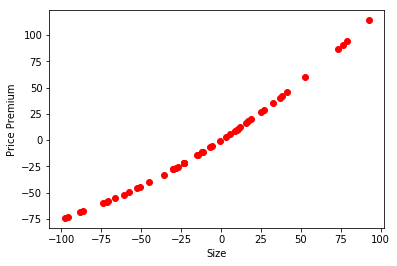

In [3]:
# I will give you the data via a function (so I can easily alter the data in subsequent examples)
v1, a1 = 1, .005
X, y = gd.gen_data(num=50, v=v1, a=a1)

(xlabel, ylabel) = ("Size", "Price Premium")
gd.gen_plot(X,y, xlabel, ylabel)

### Here's what the data looks like (life is so much easier with Pandas !)

In [4]:
import pandas as pd
df = pd.DataFrame( { "X": X.ravel(), "Y":y.ravel()})
df.head()

df.describe()

,X,Y
0,24.835708,26.377739
1,-6.913215,-6.793734
2,32.384427,35.006305
3,76.151493,90.649117
4,-11.707669,-11.364995


,X,Y
count,50.000000,50.000000
mean,-11.273695,-5.616563
std,46.683439,45.278755
min,-97.983506,-73.981587
25%,-43.048955,-38.374426
50%,-11.707258,-11.364609
75%,16.813778,17.521546
max,92.613909,114.057250


#### But if we don't have Pandas, Numpy to the rescue:

In [5]:
print("Y:\n size={}\n mean={}\n std={}\n min={}\n max={}\n".format( 
      y.size,  y.mean(), y.std(), y.min(), y.max()
                                                                  )
     )

Y:
 size=50
 mean=-5.616563210748966
 std=44.823680417643054
 min=-73.98158747882019
 max=114.05724968049518



In [6]:
# For the sharp-eyed: note the difference between y.std() and df["Y"].std()
# We prove below that this is because they are using different denominators (population vs sample) in the std. deviation calculation
print("y.std() = {ys:3.2f}, df[\"Y\"].std() = {Ys:3.2f}".format(ys=y.std(), Ys=df["Y"].std()) )
      
print (  (y.size *y.std()**2) -  ( (y.size-1) * df["Y"].std()**2 )   )

y.std() = 44.82, df["Y"].std() = 45.28
0.0


### Nothing better than visualizing !

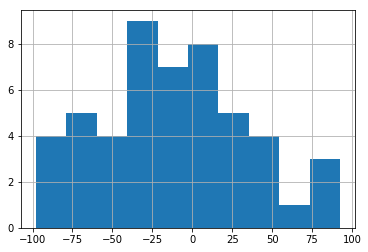

In [7]:
_ = df["X"].hist()  # See why Pandas is so convenient ?

# BTW, what's with this "_ = ..." business ?

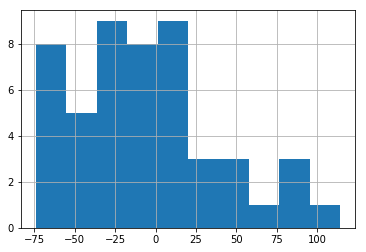

In [8]:
_ = df["Y"].hist()

#### But if we don't have Pandas, can use Matplotlib

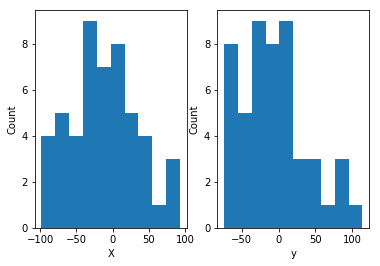

In [9]:
# Use the Object-Oriented interface to Matplotlib, NOT the MATLAB interface
# Create a figure
fig = plt.figure()

# Create a histogram for X.  The figure will be 1 row by 2 columns and the plot for X will be in column 1
ax = fig.add_subplot(121)
_ = ax.hist(X)
_ = ax.set_xlabel("X"); _ = ax.set_ylabel("Count")

# Create a histogram for Y.  The figure will be 1 row by 2 columns and the plot for X will be in column 2
ax = fig.add_subplot(122)
_ = ax.hist(y)
_ = ax.set_xlabel("y"); _ = ax.set_ylabel("Count")


### Create a test set and put it aside !
- Our ultimate goal is to predict well, out of sample
- This is called *generalization*
- Our success on the test set is our final measure
- We will revisit this later
    - Bottom line: you may look at the test set *only once*, at the end

In [10]:
def split(X,y, shuffle=True, pct=.80, seed=42):
    """
    Split the X and y datasets into two pieces (train and test)
    
    Parameters
    ----------
    X, y: ndarray.
    
    pct: Float.  Fraction (between 0 and 1) of data to assign to train
    seed: Float.  Seed for the random number generator
    
    Returns
    -------
    Tuple of length 4: X_train, X_test, y_train, y_test
    """
    # Random seed
    rng = np.random.RandomState(42)
    
    # Number of observations
    num = y.shape[0]
    
    # Enumerate index of each data point  
    idxs = list( range(0, num))
    
    # Shuffle indices
    if(shuffle):
        rng.shuffle(idxs)
    
    # How many observations for training ?
    split_idx = int( num * pct)
    
    # Split X and Y into train and test sets
    X_train, y_train = X[ idxs[:split_idx] ] , y[ idxs[:split_idx] ]
    X_test,  y_test  = X[ idxs[split_idx:] ],  y[ idxs[split_idx:] ]
                        
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = split(X,y)

X_train.shape, X_test.shape
y_train.shape, y_test.shape

((40, 1), (10, 1))

((40, 1), (10, 1))

In [12]:
type(X)
type(X_train)

numpy.ndarray

numpy.ndarray

## Discover and Visualize Data to gain insights

- Our goal is to come up with a Hypothesis (Model) that explains the relation between features(X) and targets (y)
- We explore our data to search for features that may aid in predicting the target
- This may suggest an initial Hypothesis

We do this on the **training** data only ! No peeking at the test data !

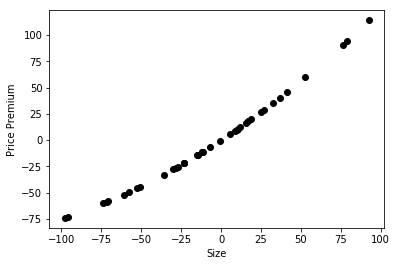

In [13]:
# Plot the target vs one feature
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)

_ = ax.scatter(X_train, y_train,  color='black')
_ = ax.set_xlabel(xlabel)
_ = ax.set_ylabel(ylabel)

Relationship between Size and Price could be linear.

That will be our initial hypothesis

## Prepare the data
- Your exploration of the data may have revealed issues that need to be addressed before modeling
    - Dirty data
    - There may be features at vastly different scales; may need to re-scale
    - Need to select or eliminate features
    - Need to create synthetic features
        - How to handle Categorical features ?
        - How to handle non-numeric features, e.g., Text

In the Toy example, everything is clean and perfect, so nothing to do just yet.

We will revisit this in the module on Data Transformations.

### Data Cleaning

Discussed in Geron; we will address this in the module on Data Transformation.

### Feature scaling
Discussed in Geron; we will address this in the module on Data Transformation.

### Data Transformations
Discussed in Geron; we will address this in the module on Data Transformation.

## Select and Train a model

 We form an hypothesis that relates features to targets.  
 Our visualization of the data suggests that a reasonable first hypothesis is a linear relation.
 
 The **model** is a tool that implements our hypothesis.
 Various terms are used:
 - hypothesis
 - estimator
 - prediction function


        

### Notation and Terminology (again)

- $(x, y)$ is an observation: a **feature** $x$ and and output value $y$
    - Will use **label**, **target** as synonyms for output value
    
    - $x$ is a *vector*: the features from a single observation
        - $x_j$ denotes the $j^{th}$ element of vector $x$
    - $y$ is a scalar value (for now)
    
We are usually given **training data**, a set of $(x, y)$ pairs
   - So each observation $(x,y)$ is one element of the training data
   - $x^i, y^i$ denote the $i^{th}$ observation
   
**Notation Summary**
- subscripts to index elements of a vector
- superscripts to index elements of a set

An **hypothesis** is a mapping from feature to target
- $\hat{y} = h_\Theta (x)$
    - $\hat{y}$ is the **predicted value**, conditional on given feature vector $x$
    - $\Theta$ is a  column vector of parameters of our model
    

Our visualization has led us to form a Linear Hypothesis.

$$h_\theta(x) = \theta_0 + \theta_1 * x$$

We can write this in vector form as 
$$h_\theta(x) = \Theta^T \cdot x$$
- Select an sklearn estimator that implements this hypothesis: `LinearRegression`
- **Fit** the model to the training data

### Model fitting: an optimization problems

**Model fitting** takes the training data and solves for $\Theta$.

Fitting most models usually involves the solution of an **Optimization Objective**.
- If we are minimizing: the optimization objective is called the **cost** function
- If we are maximizing: the optimization objective is called the **utility** function

The basic purpose of the optimization objective is to cause predictions to be close to the true values.

There may be added elements (e.g., constraints) of the objective as well (discussed later).

It is important to understand the Optimization Objective.  It tells you *why* the model fit is acting as it does.  It will guide you in your decisions for, e.g,, data transformations.

This will be a topic for a separate module on Model Math.

*The optimization objective is not necessarily identical to the performance measure.*
- constraints added to objective
- differentiability

For our first example, the Performance Measure and Cost Function will be identical.

### Optimization Objective for Linear Regression

Cost function = MSE

Minimize Cost Function by solving for $\Theta = (w, b)$ 

$$ 
\begin{array}{lll}
& \Theta & = & \textrm{argmin}_{w, b} { \sum_i \big(  (\hat{y}^i - y_i)^2 \big) } & \\
& \Theta & = & \text{argmin}_{w.b} { \sum_i \big( (w^\mathsf{T} x_i  + b) - y_i)^2} \big) & \\
& \Theta & = & \text{argmin}_{w, b} \sum_i || w^\mathsf{T}x_i + b  - y_i||^2  & \textrm{ (the L2-norm) } \\
\end{array}
$$


### LinearRegression model in sklearn

In [14]:
# Say it in code

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
_ = regr.fit(X_train, y_train)

# The coefficients
print('Coefficients: \n', regr.intercept_, regr.coef_)
print("\nShape of intercept: {i}; shape of coefficients: {c}".format(i=regr.intercept_.shape,
                                                                   c=regr.coef_.shape) )

Coefficients: 
 [4.93224426] [[0.96836946]]

Shape of intercept: (1,); shape of coefficients: (1, 1)


### Let's Predict !

In [15]:
# Recall: one way to turn a 1D ndarray into 2D is using reshape
np.array([100]).reshape(-1,1)

array([[100]])

In [16]:
# One prediction
t = [100]

# Remember: want a 2D ndarray
t_array = np.array(t).reshape(-1,1)

print("For size {s}, predicted {attr} {d}".format(s=t, attr=ylabel, d=regr.predict(t_array)))

For size [100], predicted Price Premium [[101.76919047]]


In [17]:
# Lots of predictions: predict on entire test set
y_pred = regr.predict(X_test)

### How did we do ?  Evaluate the Performance Measure
- Measure the performance
- Interpret the results
    - do the results suggest room for improvement (i.e, the next experiment) ?

In [18]:
# The mean squared error
rmse = np.sqrt( mean_squared_error(y_test,  y_pred))
print("Root Mean squared error: {:.2f}".format( rmse ) )

# Explained variance score: 1 is perfect prediction
print("R-squared: {:.2f}".format(r2_score(y_test, y_pred)) )

Root Mean squared error: 6.86
R-squared: 0.98


What do these numbers mean ?
- Relative to the given test set
    - our price premium predictions are with +/- 7
- Let's visualize the fit

#### Visualize the fit

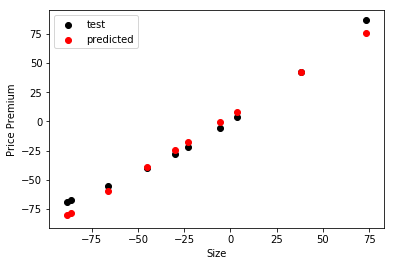

In [19]:
# Plot predicted ylabel (red) and true ylabel (black)
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)

_ = ax.scatter(X_test, y_test, color='black', label="test")
_ = ax.scatter(X_test, y_pred, color="red",   label="predicted")
_ = ax.set_xlabel(xlabel)
_ = ax.set_ylabel(ylabel)
_ = ax.legend()

Since model is linear, we can plot a fitted line

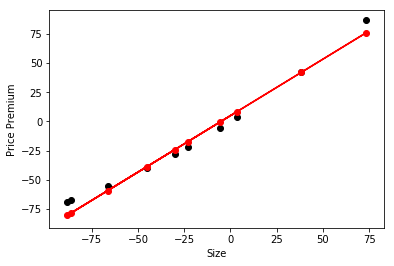

In [20]:
# Plot predicted ylabel (red) and true  (black)
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)

_ = ax.scatter(X_test, y_test, color='black', label="test")
_ = ax.scatter(X_test, y_pred, color="red",   label="predicted")

_ = ax.plot(X_test, y_pred, color="red")
_ = ax.set_xlabel(xlabel)
_ = ax.set_ylabel(ylabel)

#### Visualize the distribution of errors

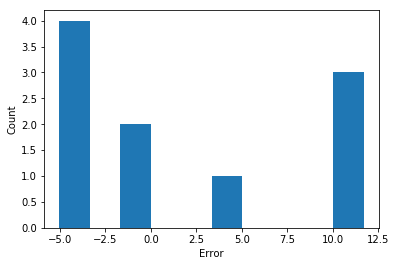

In [21]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
_ = ax.hist( (y_test - y_pred) )
_ = ax.set_xlabel("Error")
_ = ax.set_ylabel("Count")

What does the histogram tell you ?
- Maybe a problem in fitting the "tails"

#### Aside: in-sample metric

Note, this "fitted line" is out-of-sample (evaluated on the test set)

Out of curiousity, how did we do "in-sample" (evaluated on the training set)

In [22]:
# Predict on entire training set
y_pred_train = regr.predict(X_train)

# The mean squared error
rmse = np.sqrt( mean_squared_error(y_train,  y_pred_train))
print("Root Mean squared error: {:.2f}".format( rmse ) )

# Explained variance score: 1 is perfect prediction
print("R-squared (train): {:.2f}".format(r2_score(y_train, y_pred_train)) )



Root Mean squared error: 6.56
R-squared (train): 0.98


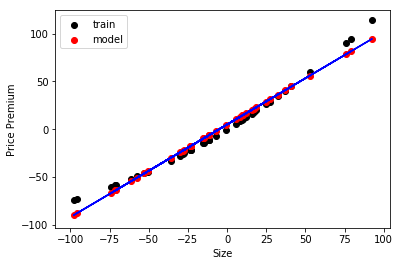

In [23]:

fig = plt.figure()
ax  = fig.add_subplot(1,1,1)

_ = ax.scatter(X_train, y_train, color="black",    label="train")
_ = ax.scatter(X_train, y_pred_train, color="red", label="model")

_ = ax.plot(X_train, y_pred_train, color="blue")
_ = ax.set_xlabel(xlabel)
_ = ax.set_ylabel(ylabel)
_ = ax.legend()

- In sample RMSE, $R^2$ similar to out of sample
    - No over/under fitting
- The "fitted model" (i.e., fitted training data) already shows a problem in the tails

#### In-sample vs Out of sample
- Traditional statistics (contrasted to ML)
    - evaluate in-sample
        - goal is to "explain" rather than predict (retrospective)
        - can predict under the *assumption that the future will be the same as the past*
    - comes with confidence intervals, etc.
        - sadly, often missing from ML

### Iterative improvement
- Our model is pretty good !
    - Do we need to iterate in this case ?
        - decent RMSE, but clearly a problem in the tails
    - In general: you will observe where the model did well and did less well
        - will lead you to a new experiment
            - Feature iteration
                - adding a previously discarded feature
                - creating a synthetic feature
            - Hypothesis iteration
                - maybe a Linear model with a single parameter is not best ?
                    - how about a second order model (e.g., $X$ and $X^2$ as features
                - maybe a different model would be better (e.g., Tree)
                
Hopefully, we've made our point with the toy example and we won't iterate further.

## Fine-tuning your model

Once we are satisfied with our Hypothesis, there may be some "knobs" to adjust for even better results

- Hyper-parameters
- GridSearch
- Ensembles

- We will visit this later

# Recipe for ML (second visit)

## Selecting a model (re-visited)

Suppose we're given a different dataset.  Let's try out our recipe and see what changes might be needed

Here's what the first dataset looked like


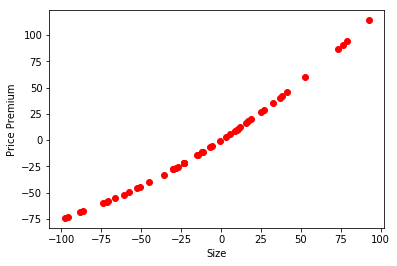

In [24]:
X_orig, y_orig = gd.gen_data(num=50, v=v1, a=a1)

gd.gen_plot(X_orig, y_orig, xlabel, ylabel)

And here's what the new dataset looks like

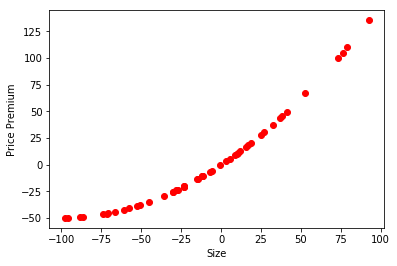

In [25]:
v2, a2 = v1, a1*2
X_curve, y_curve = gd.gen_data(num=50, v=v2, a=a2)
gd.gen_plot(X_curve,y_curve, xlabel, ylabel)

Hmm.  Looks like a lot more curvature, maybe we need a better hypothesis than a linear model ?

Let's verify this by seeing the result on the linear model.


Enough of this in-line hacking!  Combine into a couple of re-usable routines to make running and evaluating competing models easier.

<div class="alert alert-block alert-success">
<b>TIP</b>


- Copy-and-paste in notebooks is discouraged: it is error-prone (hard to be consistent once you make a change) and not very re-usable.

- Invest the time into creating routines.  Even better: create Python Classes, with flexible, reusable methods.
 </div>
 
This will add a little overhead to your startup, but will pay dividends in the long-run.

- **Gotcha**: beware of re-evaluating an earlier cell that references a variable that was changed in a later cell !
    - I use the variables `X_train, X_test, y_train, y_test` for both the first and second example
    - If, after running the second example, I re-run a cell associated with the first: confusion !


In [26]:
# %load recipe_regress.py
def plot_fit(X, y, ax=ax, on_idx=0):
    """
    Plot the fit
    
    Parameters
    ----------
    X: ndarray of features
    y: ndarray of targets
    ax: a matplotlib axes pbject (matplotlib.axes._subplots.AxesSubplot)
    
    Optional
    --------
    on_idx: Integer.  Which column of X to use for the horizontal axis of the plot
 
    """
    sort_idx = X[:, on_idx].argsort()
    X_sorted = X[ sort_idx,:]
    y_sorted = y[ sort_idx,:]
    
    _ = ax.plot(X_sorted[:, on_idx] , y_sorted, color="red")
    
def transform(X):
    """
    Add a column to X with squared values
    
    Parameters
    ----------
    X: ndarray of features
    """
    X_p2 = np.concatenate( [X, X **2], axis=1)
    return X_p2
    
def run_regress(X,y, run_transforms=False):
    """
    Do the full pipeline of the regression of y on X
    
    Parameters
    ----------
    X: ndarray of features
    y: ndarray of targets
    
    Optional
    --------
    runTransforms: Boolean.  If True, run additional data transformations to create new features
    """
    X_train, X_test, y_train, y_test = split(X,y)
    
    # Transform X's
    if (run_transforms):
        X_train = transform(X_train)
        X_test  = transform(X_test)

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    _ = regr.fit(X_train, y_train)

    # The coefficients
    print('Coefficients: \n', regr.intercept_, regr.coef_)
    # Lots of predictions: predict on entire test set
    y_pred = regr.predict(X_test)

    # Explained variance score: 1 is perfect prediction
    print("R-squared (test): {:.2f}".format(r2_score(y_test, y_pred)) )

    y_pred_train = regr.predict(X_train)
    print("R-squared (train): {:.2f}".format(r2_score(y_train, y_pred_train)) )

    # Plot predicted ylabel (red) and true label (black)
    fig = plt.figure()
    ax  = fig.add_subplot(1,1,1)

    _ = ax.scatter(X_test[:,0], y_test, color='black')
    _ = ax.scatter(X_test[:,0], y_pred, color="red")

    # _ = ax.plot(X_test[:,0], y_pred, color="red")
    plot_fit(X_test, y_pred, ax=ax, on_idx=0)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel(ylabel)
    
    return


Here's our linear model on the original data

Coefficients: 
 [4.93224426] [[0.96836946]]
R-squared (test): 0.98
R-squared (train): 0.98


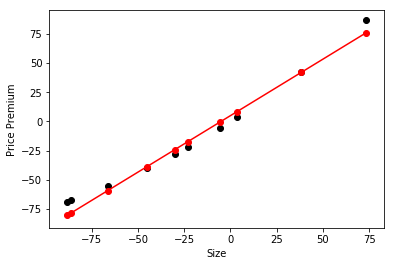

In [27]:
run_regress(X_orig, y_orig)

And now here's our linear model on the new "curvier" dataset

Coefficients: 
 [9.86448852] [[0.93673892]]
R-squared (test): 0.91
R-squared (train): 0.91


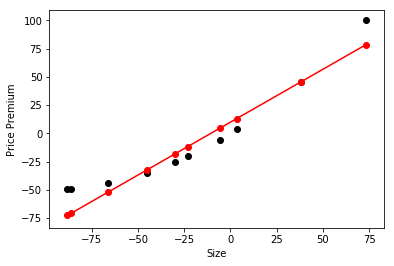

In [28]:
run_regress(X_curve, y_curve)

Not terrible, but clearly room for improvement, compared to the original dataset.

<div class="alert alert-block alert-success">
<b>TIP</b>

- Don't stop just because you scored 91%. And don't give up if the score was awful.

- Examining the errors (residuals) reveals alot about how to improve your model. 
    - Where was the fit good ? Where was it bad ? 
    - Is there a pattern to the badly fit observations that points to a missing feature ?
</div>

One of the real arts of ML is diagnosing model deficiencies and knowing how to improve them.

We will have a separate module on this topic.

How about a second degree model, with hypothesis

$$ y = \beta_0 + \beta_1 \times x + \beta_2 \times x^2$$

Fortunately, our LinearRegression model can take multiple independents !

Just append an $x^2$ column to the $x$ column (done within run_regress)

Coefficients: 
 [-7.10542736e-15] [[1.    0.005]]
R-squared (test): 1.00
R-squared (train): 1.00


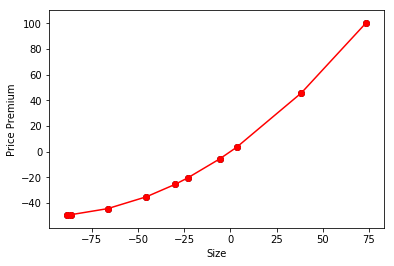

In [29]:
run_regress(X_curve, y_curve, run_transforms=True)

Perfect fit !



# Feature engineering (intro)

- Let's review what we just did:
    - we created a new hypothesis
    - we created a feature ($x^2$) that was not present among the "raw" features

- This is an illustration of  **feature engineering** and is one of the key aspects of becoming a successful
data scientist.  

- The guts is still LinearRegression but we transformed the independent variable matrix $X$ to have a new feature ($x^2$)

- Sometimes, we don't need to *add* features but instead to change an existing feature
    - e.g., converting prices to returns for financial instruments

- Deriving and transforming features is called **feature engineering**

- The sub-sections of our notebook under "Prepare the data" (e.g.,"Feature Scaling", "Data Transformations")
is where we would perform our feature engineering.

We will have an entire module on this topic but for now we'll do a quick introduction.

## Tranform both training and test data in the same way !

Let's examine the code we used to create the new feature:


` # Transform X's
    if (run_transforms):
        X_train = transform(X_train)
        X_test  = transform(X_test)
`

Clearly, we have to tranform `X_train`, but why did we transform `X_test` ?

**Feature engineeering lesson 1:** the same features should be present in training and test !
- the whole purpose of adding the feature was to aid *prediction* so must be in test set too.

## No cheating  in Feature Engineering either !

Remember, we had set aside a set of Test Data with the promise to only look at it once.

But considering that we need to apply an *identical* transformation to both the Train and Test data sets,
wouldn't it be convenient to combine this into one step ?



You may have noticed that, in `run_regress` we did **not** combine the transformations of `X_train` and `X_test` into a single call:


`    X_train, X_test, y_train, y_test = split(X,y)  
    
    # Transform X's
    if (run_transforms):
        X_train = transform(X_train)
        X_test  = transform(X_test)
`

This was very deliberate.

Couldn't we have just transformed `X` before splitting ?

    if (run_transforms):
        X = transform(X)
    
    X_train, X_test, y_train, y_test = split(X,y)  
`

**Question**: Why might this be a bad idea ?

By mixing `X_train` and `X_test` we create the *possibility* of inadvertantly "leaking" information from the Test data set into the Train data set.  That would amount to "peeking"
- Consider a transformation that replaces missing values in a column with the mean of the column
    - Replace missing values in `X_train` with `X_train.mean()` **NOT** `X.mean()`
    
**Feature engineeering lesson 2:** Apply the *same* transformations to Train and Test, but *independently*

This was our first (but hardly our last) Data Transformation.  Lots more to come.

## Pipelines

We applied only a single transformation but, in general, there may be *multiple* transformations to apply.

We have to run an **identical** sequence of transformations on the train and test datasets.

I did this above via the `transform` routine, that encapsulates all the transformations so we can apply them to both train and test consistently. 

So `transform` will become:


`
def transform(X):

    X_1 = run_transform_1(X)
    X_2 = run_transform_2(X_1)
        ...
    X_n  = run_transform_n(X_{n-1})
    
    return X_n
`

This is called a transformation "pipeline".

My implementation is less than ideal.

A good architecture like **sklearn** will supply a rich library of independent transformations and a simple way to construct pipelines


### Pipelines in sklearn



Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

Score (train):  1.0
Score (test):  1.0
Last element of pipeline: ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))
Score (test, via LinearRegression object):  0.8671060075570477
R-squared score (test): 1.00


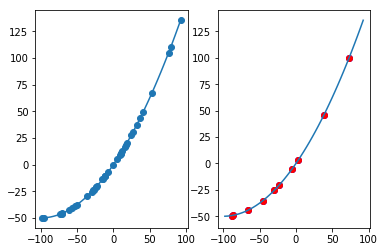

In [30]:
X_curve, y_curve = gd.gen_data(num=50, v=v2, a=a2)


X_train, X_test, y_train, y_test = split(X_curve,y_curve)

xfit = np.linspace(0, 10, 1000)

from sklearn.preprocessing import PolynomialFeatures
import sklearn.preprocessing as pre_proc

# Create the Pipeline
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(pre_proc.PolynomialFeatures(2),
                           linear_model.LinearRegression())

x=None
y=None

# Fit the model, running the data transformation first
poly_model.fit(X_train.reshape(-1,1), y_train)

xfit = np.linspace( X_train[:,0].min(), X_train[:,0].max()).reshape(-1,1)
yfit = poly_model.predict(xfit)

# Plot the results
# Create a figure
fig = plt.figure()

# Create a histogram for X.  The figure will be 1 row by 2 columns and the plot for X will be in column 1
ax = fig.add_subplot(121)
_= ax.scatter(X_train,y_train)
_ =ax.plot(xfit, yfit);

# Prediction based on test set
y_pred = poly_model.predict(X_test.reshape(-1,1))

# In and out of sample scores
print("Score (train): ", poly_model.score(X_train.reshape(-1,1), y_train))
print("Score (test): ",  poly_model.score(X_test.reshape(-1,1),  y_test))

# Accessing just PART of the Pipeline: the last (i.e, regression) step
print("Last element of pipeline:", poly_model.steps[1])
regr_ = poly_model.steps[-1]

# NOTE: this accesses the last element of the pipeline WITHOUT having run the earlier steps !  So no Polynomial transformation !
print("Score (test, via LinearRegression object): ",  regr.score(X_test.reshape(-1,1),  y_test))

ax = fig.add_subplot(122);
_ = ax.scatter(X_test, y_test, color="blue")
_ = ax.scatter(X_test, y_pred, color="red")

_ = ax.plot(xfit, yfit)


print("R-squared score (test): {:.2f}".format(r2_score(y_test, y_pred)) )

That was a handful ! Let's break it down into smaller bites.



`make_pipeline` creates a "pipeline" which we assign to `poly_model`

The pipeline has two steps:
- `pre_proc.PolynomialFeatures(2)`
    - creates polynomial features up to degree 2
- `linear_model.LinearRegression()`
    - this actually runs the linear regression !
        - In addition to `fit` and `predict` methods, models can also do `transform`

Let's examine the internals of the Pipeline object

In [31]:
poly_model.steps
poly_model.steps[-1]

[('polynomialfeatures',
  PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)),
 ('linearregression',
  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
           normalize=False))]

('linearregression',
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False))

- `poly_model.steps`
    - An array of steps of the pipeline
- `poly_model.steps[-1]`
    - The last step in the pipeline, e.g, `LinearRegression`
- Note in my code how I extracted the last step and used it indepdently of the pipeline:

`

Here's a slightly longer pipeline from 
[VanderPlas](external/PythonDataScienceHandbook/notebooks/05.04-Feature-Engineering.ipynb#Feature-Pipelines)

- `Imputer` to deal with misssing values
- `PolynomialFeatures(degree=2)`
- `LinearRegression()`

#### Advanced Pipelines: FeatureUnion

A pipeline successively applies transformation, starting with the input, and resulting in a transformed output.

You can create separate pipelines and join their outputs (horizontally) useing `FeatureUnion1


- Separate pipelines to deal with distinct subsets of column types (numeric and non-numeric)
- First step in each pipeline is to restrict the inputs to the relevant columns
- So net effect is: one set of transformations for numeric columns and a separate set for non-numeric

# Create a test set and put it aside (re-visited)

Why did we shuffle the data before splitting ?

# Selecting a model (another re-visit)


sklearn has LOTS of models to choose from.  We will explore many (but not all) of them.

Your goal should be to understand *how* a model does it fitting (i.e., model math) so that you can determine
- what is the right model to use for my data
- what transformations of my data will make my model perform better

You can explore Linear Regression in depth [here](external/PythonDataScienceHandbook/notebooks/05.06-Linear-Regression.ipynb)

# Challenge: Overfitting

We had great sucess when we create second order polynomial features.

Why stop at 2 ?

Below we will create a simple-to-describe target ($\textrm{sin}(x)$) with a complex shape and try to fit it with a higher order polynomial.


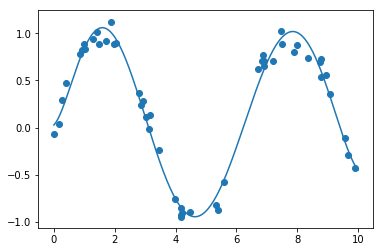

In [32]:
xfit = np.linspace(0, 10, 1000)

from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline
degree = 7
poly_model = make_pipeline(PolynomialFeatures(degree),
                           linear_model.LinearRegression())
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

Can the $7^{th}$ degree polynomial *really* be called learning ?

Why 7 ?  Why not 100 ?

We can fit an arbitrary function with a spline or polynomial of high enough degree, but the model that recognizes this as a sine is more akin to "learning" ?
- with a high enough degree, we will start to "memorize" the training set, even down to the noise
- won't generalize well


This is know as *over-fitting*
- Symptom: When test score is much worse than training score

It may be an indication that your model has merely memorized the training data and not learned anything at all that will help it predict on an unseen observation.  Even worse, your training data is often noisy (e.g., minor measurment errors) and a model with too many degrees of freedom will reproduce the noise !

## Regularization: reducing overfitting
What can we do to combat over-fitting ?

Recall that LinearRegression model is optimizing a Cost Function.  We will add a *weighted penalty* 

$$P = \alpha * Q$$

to the Cost Function in order to impose a cost on using too many degrees of freedom.

The weight $\alpha$ balances the original Cost fuction with the penalty.

We'll show several modified Regression models and identify the penalty used

### [Ridge Regression](external/PythonDataScienceHandbook/notebooks/05.06-Linear-Regression.ipynb#Ridge-regression-%28$L_2$-Regularization%29)

Penalty is: sum (over parameters) of squared paramter value

$$
P = \alpha\sum_{n=1}^N \theta_n^2
$$

Also known as $L_2$ regularizer.

This tends to push parameters $\theta_n$ towards smaller values.

### [Lasso Regression][1]
[1]: external/PythonDataScienceHandbook/notebooks/05.06-Linear-Regression.ipynb#Lasso-regression-($L_1$-regularization)


Penalty is: sum (over parameters) of parameter's absolute value
$$
P = \alpha\sum_{n=1}^N |\theta_n|
$$

Also know as the $L_1$ regularizer.

This tends to push parameters $\theta_n$ towards 0

<div class="alert alert-block alert-success">
    <b>TIP</b> 

- Know your Cost Function !  
    - This is what is driving your model's fitting process.  Does it make sense for your problem ?

- Don't try to force a square peg into a round hole.
</div>

We will have a separate module on understanding the Mathematics of fitting.

# The sklearn API

fit, transform

fit_transform

predict

[Scikit-learn cheat sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

# How is this different from plain old OLS regression ?

- generalization vs explanation
    - traditional OLS seeks to explain the data
        - in-sample (training) performance measure
        - to the extent we believe the past is representative about the future, we can also use it to predict
        - statistical tests, confidence intervals are basic principle
    - the true test of ML is how well it generalizes: predicts the future
        - out-of-sample performance measure
        

 - Confidence intervals:
    - sadly: missing or down-played in ML
        - for "big" data or models, fitting may be time-consuming
        - costly to create empirical distributions
            - we WILL address this in Cross-Validation

# Validation and Cross-Validation

- Why did we separate out a test set from our complete dataset ?

- Recall our goal is good, out-of-sample prediction.  And the test set is our benchmark for generalization.
If we look at the test set in the middle of our process, it will influence our final model.  We may thus wind up with a good score on the test set, but generalize poorly to a completely unseen observation.

- It's like seeing the answers to an exam in advance ! Don't do it !  You can only look at it *ONCE*, when you're all done, if you want a truly honest indicator of generalization.

## Validation

[Geron notebook](external/PythonDataScienceHandbook/notebooks/05.03-Hyperparameters-and-Model-Validation.ipynb#Thinking-about-Model-Validation)

- But wait ! During our iterative process (Selecting the model, Training it, and Evaluating the performance) we look at the training data many times.  We really have no indication as to how it will generalize.  And we're in danger of severely over-fitting to the training data.

What can we do ?

- Answer: Split the *training data* into two pieces
    - a smaller training data
    - a *hold-out* piece called the *validation* set
        - the validation set serves a similar role to the test set.
        - it is used to see how well the model generalizes
        - you can use the validation set *many* times (sort of) during your iterative process
            - unlike the test set, which you may look at only once, at the end
        

**Aside**

So much splitting of data !

Rather than using my own, hand-rolled splitter, we will henceforth use sklearn's `train_test_split` function.

Splitting into a smaller training set, and a validation set, is a step in the right direction.


## Cross-Validation

You might still be uncomfortable with the idea of a validation set that is used many times.  Rightly so.
- We can wind up over-fitting to the validation set.  Isn't this cheating too ?
- The smaller training set is smaller -- may be a problem if we don't have much training data to begin with.
- The validation set is just *one* sample. How do we know the Performance Measure on this one sample is representative ?
    - Where are the error bars or confidence intervals for this statistic ?
    
Cross-Validation to the rescue !

**K-fold cross-validation**
- Split the training data into $K$ pieces (called *folds*. so K-fold means $K$ pieces.
- Select one piece as the validation set, and the other $(K-1)$ pieces as the smaller training set
    - Fit the model on the smaller training set
    - Evaluate the Performance measure on this validation set
- Repeat the above $(K-1)$ times, using a different fold as the validation set and the other folds as training.

At the end, you have $K$ values for the Performance measure.  This is akin to getting a statistical confidence interval for an estimator. 

Typically, we just use the average but it's good to know how wide the range is.
    

This sounds like a lot of work.

Fear not !

sklearn has a function to do this for us: `cross_val_score1

>`from sklearn.cross_validation import cross_val_score
 cross_val_score(model, X, y, cv=5)`
 
This will do $5$-fold cross-validation ('cv=5`) on `model` using training features `X` and targets `y`.

It will return $5$ scores, one per validation fold.

**ASIDE**
Recall that there are several steps in creating a model, including
- data transformations
- fitting

You need to run *all* these steps each time you train the model.  In K-fold cross-validation, you are training a model $K$ times.  How do we get `cross_val_score` to run all these steps for us, each time ?

Pipelines ! (Introduced [above](Recipe_for_ML.ipynb#Pipelines))

The trick is to include your model as the *last* step of the Pipeline.  Models are just like other transformations in that they respond to `fit`, `transform` and `fit_transform` methods.

Running a Pipeline just calls `fit_transform` on each member in sequence.  All but the last massage your data.  But the last (the model) will actually fit our model !


Here's the final picture

![](images/Cross_Validation_Split.jpg)


# Fine-tuning  your model (Geron, last part Chapt 2)
- GridSearch

- RandomizedSearch

- Ensembles

- Analyze models and errors
    - parameter interpretation

# What does this have to do with Finance ?

- Stock market "beta": how much does a stock move, for a 1% move in the index ?
    - Typically calcuated using LinearRegression, with some window
    - But who says this is the "best" (gives best prediction) window ?
        - we can address this in Cross-Validation
- Multi-factor models
    - LinearRegression with multiple regressors

# Recap



In [33]:
print("Done !")

Done !
